# Differentially Private Spatial Decompositions demo
## ...and their applications for spatial cluster detection

This repository seeks to do two things:
1. Provide general-purpose implementations of (some of) the methods described in Cormode et al.'s "Differentially Private Spatial Decompositions"
2. Explore how differentially private spatial decompositions can be applied to the specific subtask of performing spatial cluster/anomaly detection in a differentially private setting

### Status of goal 1

- [x] Implement classical (i.e., non-private) quadtree spatial decomposition
    - [x] Implement privatization logic for quadtree
- [ ] Implement classical kd-tree spatial decomposition
    - [ ] Implement privatization logic for kd-tree
- [ ] Implement techniques for improving query accuracy (e.g., building an OLS estimator of the true count value as described in Cormode et al.)

### Status of goal 2
- [x] Generate some data from a Poisson point process, and try to find
- [x] Implement naive (inefficient) logic for computing scan statistic over a quadtree
- [x] Implement naive (inefficient) logic for finding circular region of max anomalousness over a quadtree
- [ ] Implement randomization testing (or something more efficient) to tets anomalous regions for significance

## Example: generate some points
Generates some points according to a Poisson point process.

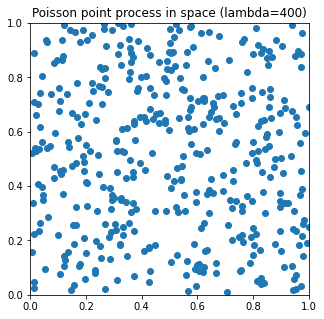

In [501]:
from shapely import geometry
from cormode import gen
from matplotlib import pyplot as plt

lambda_poisson = 400

points = gen.generate_points_no_cluster(geometry.box(0,0,1,1), lambda_poisson)
points_x, points_y = ([x for (x, _) in points], [y for (_, y) in points])

plt.figure(figsize=(5,5))
plt.title(f"Poisson point process in space (lambda={lambda_poisson})")
plt.xlim(0,1)
plt.ylim(0,1)
plt.scatter(points_x, points_y)

## Build a quadtree
A quadtree is a kind of spatial decomposition that recursively divides space into quadrants. It can be used to efficiently count the number of points within a given region. 

In [502]:
from cormode.classical import QuadTreeNode

# height is the maximum number of edges from root to leaf.
# since each level subdivides space into quadrants, level i represents a 2^i by 2^i grid.
tree = QuadTreeNode(height = 2) 

# inserting a point into the quadtree increments the count at each node containing the point.
for point in points:
    tree.insert_point(point)

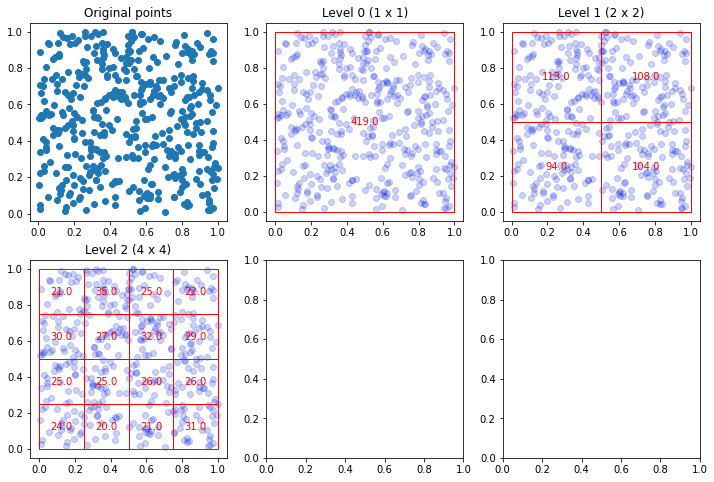

In [503]:
fig, axes = plt.subplots(1 + ((tree.height + 1) // 3), 3, figsize=(12,8))

axes[0][0].set_title("Original points")
axes[0][0].scatter(points_x, points_y)

# draw example using level-order traversal
nodes = [tree]
for level in range(tree.height + 1):
    next_nodes = []
    ax = axes[(level + 1) // 3][(level + 1) % 3]
    ax.set_title(f"Level {level} ({2**level} x {2**level})")

    ax.scatter(points_x, points_y, color=(0.0, 0.1, 0.9, 0.2))

    for node in nodes:
        rect = plt.Rectangle((node.rect.xmin, node.rect.ymin), (node.rect.xmax - node.rect.xmin), (node.rect.ymax - node.rect.ymin), facecolor=(0,0,0,0), edgecolor="red")
        ax.add_patch(rect)

        center_x = (node.rect.xmin + node.rect.xmax) / 2
        center_y = (node.rect.ymin + node.rect.ymax) / 2

        if level < 4:
            ax.text(center_x, center_y, str(node.count), horizontalalignment="center", verticalalignment="center", color="red")

        if not node.is_leaf:
            next_nodes += node.children
    
    nodes = next_nodes

## Execute queries against a quadtree

Having built the quadtree, we can use it to efficiently count how many points fall inside a given region.

Quadtree estimate of points in region: 86.25508349001332 (3.08% error)
True number of points in region: 89


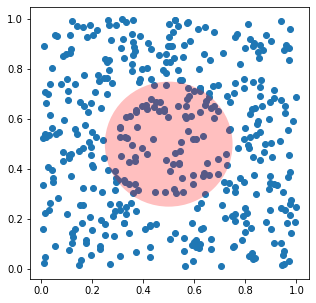

In [504]:
circle_x, circle_y = 0.5, 0.5
circle_radius = 0.25
query = geometry.Point(circle_x,circle_y).buffer(circle_radius)

plt.figure(figsize=(5,5))
plt.scatter(points_x, points_y)
plt.gca().add_patch(plt.Circle((circle_x, circle_y), circle_radius, facecolor=(1,0,0,0.25)))

quadtree_estimate = tree.count_inside(query)
true_count = len([(x,y) for (x,y) in points if query.contains(geometry.Point(x,y))])
print(f"Quadtree estimate of points in region: {quadtree_estimate} ({100 * abs(quadtree_estimate - true_count) / true_count:.2f}% error)")
print(f"True number of points in region: {true_count}")

## Building a private quadtree
We can turn the non-private quadtree above into a private quadtree by adding noise to the counts on each level. This process is described in detail in Cormode et al.'s original paper.

In [505]:
from cormode import private

# overall privacy parameter
EPSILON = 1.0
# uses geometric budgeting strategy from Cormode et al.
private_tree = private.make_private_quadtree(tree, EPSILON, budget_strategy=private.BudgetStrategy.GEOMETRIC)

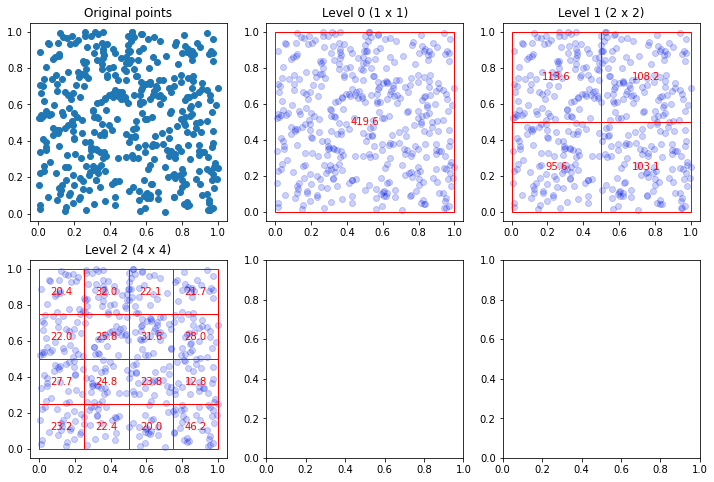

In [506]:
fig, axes = plt.subplots(1 + ((tree.height + 1) // 3), 3, figsize=(12,8))

axes[0][0].set_title("Original points")
axes[0][0].scatter(points_x, points_y)

# draw example using level-order traversal
nodes = [private_tree]
for level in range(private_tree.height + 1):
    next_nodes = []
    ax = axes[(level + 1) // 3][(level + 1) % 3]
    ax.set_title(f"Level {level} ({2**level} x {2**level})")

    ax.scatter(points_x, points_y, color=(0.0, 0.1, 0.9, 0.2))

    for node in nodes:
        rect = plt.Rectangle((node.rect.xmin, node.rect.ymin), (node.rect.xmax - node.rect.xmin), (node.rect.ymax - node.rect.ymin), facecolor=(0,0,0,0), edgecolor="red")
        ax.add_patch(rect)

        center_x = (node.rect.xmin + node.rect.xmax) / 2
        center_y = (node.rect.ymin + node.rect.ymax) / 2

        if level < 4:
            ax.text(center_x, center_y, f"{node.count:.1f}", horizontalalignment="center", verticalalignment="center", color="red")

        if not node.is_leaf:
            next_nodes += node.children
    
    nodes = next_nodes

## Execute queries against the private quadtree
Now, we can use the private quadtree just like the non-private one; we can execute queries and get a (private) estimate of how many points fall inside a given region.

Non-private quadtree estimate of points in region: 88.71559916714567 (0.32% error)
Private quadtree estimate of points in region: 77.95607940350006 (12.41% error)
True number of points in region: 89


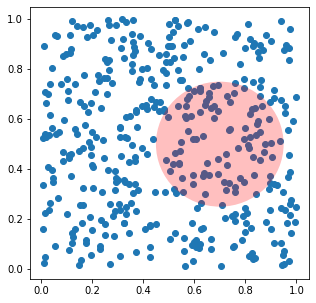

In [507]:
circle_x, circle_y = 0.7, 0.5
circle_radius = 0.25
query = geometry.Point(circle_x,circle_y).buffer(circle_radius)

plt.figure(figsize=(5,5))
plt.scatter(points_x, points_y)
plt.gca().add_patch(plt.Circle((circle_x, circle_y), circle_radius, facecolor=(1,0,0,0.25)))

quadtree_estimate = tree.count_inside(query)
private_quadtree_estimate = private_tree.count_inside(query)
true_count = len([(x,y) for (x,y) in points if query.contains(geometry.Point(x,y))])
print(f"Non-private quadtree estimate of points in region: {quadtree_estimate} ({100 * abs(quadtree_estimate - true_count) / true_count:.2f}% error)")
print(f"Private quadtree estimate of points in region: {private_quadtree_estimate} ({100 * abs(private_quadtree_estimate - true_count) / true_count:.2f}% error)")
print(f"True number of points in region: {true_count}")

# Spatial cluster detection
Now that we have mechanisms for privately indexing points in space and executing counting queries on arbitrary regions, we can try applying spatial cluster detection methods. We start by generating data.

## Generate data
We generate data according to a Poisson point process, assuming the presence of a single cluster with an elevated Poisson parameter.

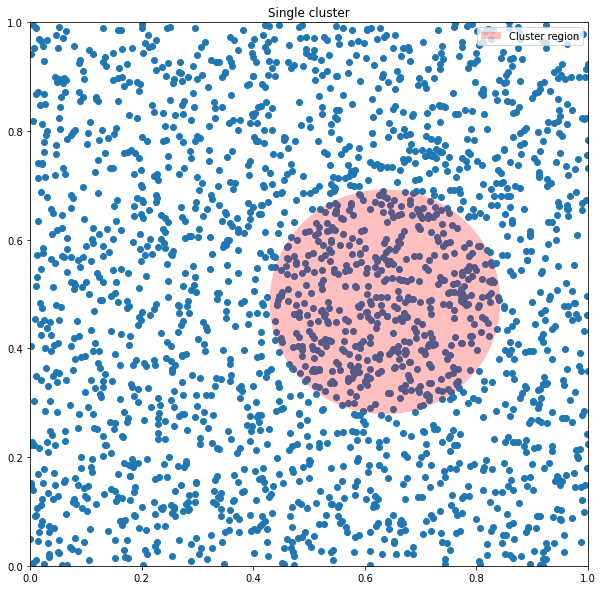

In [508]:
import numpy as np
from matplotlib.patches import Patch

population = 400_000 # a city of 400,000 people
background_incidence_rate = 0.005 # 0.5% incidence outside of cluster
cluster_incidence_rate = 0.01 # 1% incidence inside cluster

lambda_background = background_incidence_rate * population
lambda_cluster = cluster_incidence_rate * population # no need to scale by cluster area, this is handled by cormode.gen module

cluster_center = (np.random.uniform(0,1), np.random.uniform(0,1))
cluster_radius = np.random.uniform(0.1, 0.25)
cluster_region = geometry.Point(*cluster_center).buffer(cluster_radius)

points = gen.generate_points_single_cluster(
    geometry.box(0,0,1,1),
    lambda_background,
    cluster_region,
    lambda_cluster
)

plt.figure(figsize=(10,10))
plt.title("Single cluster")
plt.xlim(0,1)
plt.ylim(0,1)
points_x, points_y = ([x for x, _ in points], [y for _, y in points])
plt.scatter(points_x, points_y)
plt.gca().add_patch(plt.Circle(cluster_center, cluster_radius, facecolor=(1,0,0,.25)))

legend = [
    Patch(facecolor=(1,0,0,0.25), label="Cluster region")
]
plt.gca().legend(handles=legend, loc="upper right")


## Build quadtree over cluster data
Just as before: we build a quadtree over the cluster data, and then we perturb each node's counts to privatize it.

In [509]:
tree = QuadTreeNode(height=2)

for point in points:
    tree.insert_point(point)

EPSILON = 0.1
private_tree = private.make_private_quadtree(tree, EPSILON, budget_strategy=private.BudgetStrategy.GEOMETRIC)

## Finding maximally anomalous region
Now, we can sweep a circle over the map and calculate the scan statistic at each point to try and find the maximally anomalous region.

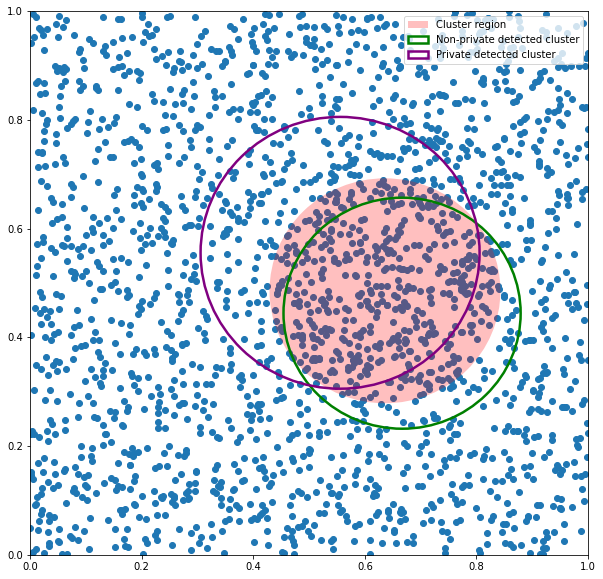

In [510]:
import cluster

nonprivate_scan_statistic, nonprivate_region = cluster.find_max_scan_statistic_sweep(tree, population)
private_scan_statistic, private_region = cluster.find_max_scan_statistic_sweep(private_tree, population)

plt.figure(figsize=(10,10))
plt.xlim(0,1)
plt.ylim(0,1)
plt.scatter(points_x, points_y)
plt.gca().add_patch(plt.Circle(cluster_center, cluster_radius, facecolor=(1,0,0,.25)))
plt.gca().add_patch(plt.Circle(*nonprivate_region,facecolor=(0,0,0,0), edgecolor="green", linewidth=2.5))
plt.gca().add_patch(plt.Circle(*private_region,facecolor=(0,0,0,0), edgecolor="purple", linewidth=2.5))

legend = [
    Patch(facecolor=(1,0,0,0.25), label="Cluster region"),
    Patch(facecolor=(0,0,0,0), edgecolor="green", linewidth=2.5, label="Non-private detected cluster"),
    Patch(facecolor=(0,0,0,0), edgecolor="purple", linewidth=2.5, label="Private detected cluster"),
]
plt.gca().legend(handles=legend, loc="upper right")